In [1]:
import numpy as np
import json
from PIL import Image, ImageDraw
import os
import cv2
import pandas as pd
from tqdm import tqdm
import shutil
import random

The purpose of this script is to explore images/annotations of the FDDB dataset.  
Also it converts face ellipses into face bounding boxes.  
Also it converts annotations into json format.

In [21]:
IMAGES_DIR = os.path.expanduser('~/datasets/fddb/originalPics/')
BOXES_DIR = os.path.expanduser('~/datasets/fddb/FDDB-folds/')
RESULT_DIR = os.path.expanduser('data/fddb/val/') 

# Read data

In [8]:
# collect paths to all images

all_paths = []
for path, subdirs, files in tqdm(os.walk(IMAGES_DIR)):
    for name in files:
        all_paths.append(os.path.join(path, name))
        
metadata = pd.DataFrame(all_paths, columns=['full_path'])

# strip root folder
metadata['path'] = metadata.full_path.apply(lambda x: os.path.relpath(x, IMAGES_DIR))

0it [00:00, ?it/s]

10it [00:00, 30.30it/s]

18it [00:00, 41.67it/s]

46it [00:00, 86.00it/s]

68it [00:00, 106.09it/s]

99it [00:00, 133.43it/s]

144it [00:00, 168.69it/s]

197it [00:00, 200.46it/s]

256it [00:01, 232.74it/s]

307it [00:01, 255.71it/s]

348it [00:01, 212.31it/s]

380it [00:01, 212.51it/s]

409it [00:01, 208.50it/s]

434it [00:02, 209.60it/s]

459it [00:02, 206.70it/s]

483it [00:02, 207.87it/s]

506it [00:02, 206.91it/s]

548it [00:02, 215.24it/s]

580it [00:02, 219.11it/s]

635it [00:02, 229.73it/s]

682it [00:02, 238.07it/s]

720it [00:02, 241.42it/s]

757it [00:03, 241.13it/s]

790it [00:03, 241.81it/s]

808it [00:03, 239.71it/s]

In [9]:
# all unique endings
metadata.path.apply(lambda x: x.split('.')[-1]).unique()

array(['jpg'], dtype=object)

In [10]:
# number of images
len(metadata)

28204

In [11]:
annotation_files = os.listdir(BOXES_DIR)
annotation_files = [f for f in annotation_files if f.endswith('ellipseList.txt')]
annotation_files = [os.path.join(BOXES_DIR, f) for f in annotation_files]

In [12]:
def ellipse_to_box(major_axis_radius, minor_axis_radius, angle, center_x, center_y):
    half_h = major_axis_radius * np.sin(-angle)
    half_w = minor_axis_radius * np.sin(-angle)
    xmin, xmax = center_x - half_w, center_x + half_w
    ymin, ymax = center_y - half_h, center_y + half_h
    return xmin, ymin, xmax, ymax


def get_boxes(path):
    
    with open(path, 'r') as f:
        content = f.readlines()
        content = [s.strip() for s in content]

    boxes = {}
    num_lines = len(content)
    i = 0
    name = None

    while i < num_lines:
        s = content[i]
        if 'big/img' in s:
            if name is not None:
                assert len(boxes[name]) == num_boxes
            name = s + '.jpg'
            boxes[name] = []
            i += 1
            num_boxes = int(content[i])
            i += 1
        else:
            numbers = [float(f) for f in s.split(' ')[:5]]
            major_axis_radius, minor_axis_radius, angle, center_x, center_y = numbers

            xmin, ymin, xmax, ymax = ellipse_to_box(
                major_axis_radius, minor_axis_radius, 
                angle, center_x, center_y
            )
            if xmin == xmax or ymin == ymax:
                num_boxes -= 1
            else:
                boxes[name].append((
                    min(xmin, xmax), min(ymin, ymax), 
                    max(xmin, xmax), max(ymin, ymax)
                ))
            i += 1
    return boxes

In [13]:
boxes = {}
for p in annotation_files:
    boxes.update(get_boxes(p))

In [14]:
# check number of images with annotations
# and number of boxes
# (these values are taken from the official website) 
assert len(boxes) == 2845
assert sum(len(b) for b in boxes.values()) == 5171 - 1  # one box is empty

In [15]:
metadata = metadata.loc[metadata.path.apply(lambda x: x in boxes)]
metadata = metadata.reset_index(drop=True)

# Show bounding boxes

In [16]:
def draw_boxes_on_image(path, boxes):

    image = Image.open(path)
    draw = ImageDraw.Draw(image, 'RGBA')
    width, height = image.size

    for b in boxes:
        xmin, ymin, xmax, ymax = b

        fill = (255, 255, 255, 45)
        outline = 'red'
        draw.rectangle(
            [(xmin, ymin), (xmax, ymax)],
            fill=fill, outline=outline
        )
    return image

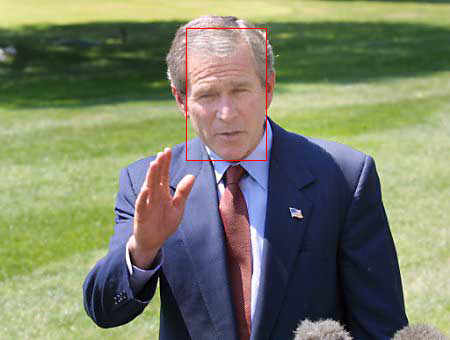

In [17]:
i = random.randint(0, len(metadata) - 1)  # choose a random image
some_boxes = boxes[metadata.path[i]]
draw_boxes_on_image(metadata.full_path[i], some_boxes)

# Convert

In [18]:
def get_annotation(path, name, width, height):
    annotation = {
      "filename": name,
      "size": {"depth": 3, "width": width, "height": height}
    }
    objects = []
    for b in boxes[path]:
        xmin, ymin, xmax, ymax = b
        objects.append({"bndbox": {"ymin": ymin, "ymax": ymax, "xmax": xmax, "xmin": xmin}, "name": "face"})
    annotation["object"] = objects
    return annotation

In [24]:
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
shutil.rmtree(RESULT_DIR, ignore_errors=True)
os.mkdir(RESULT_DIR)
os.mkdir(os.path.join(RESULT_DIR, 'images'))
os.mkdir(os.path.join(RESULT_DIR, 'annotations'))

In [25]:
for T in tqdm(metadata.itertuples()):
    
    # get width and height of an image
    image = cv2.imread(T.full_path)
    h, w, c = image.shape
    assert c == 3
    
    # name of the image
    name = '-'.join(T.path.split('/')[:3]) + '_' + T.path.split('/')[-1]
    assert name.endswith('.jpg')

    # copy the image
    shutil.copy(T.full_path, os.path.join(RESULT_DIR, 'images', name))
    
    # save annotation for it
    d = get_annotation(T.path, name, w, h)
    json_name = name[:-4] + '.json'
    json.dump(d, open(os.path.join(RESULT_DIR, 'annotations', json_name), 'w')) 

0it [00:00, ?it/s]

110it [00:00, 1095.43it/s]

220it [00:00, 1096.45it/s]

322it [00:00, 1067.83it/s]

415it [00:00, 1032.92it/s]

503it [00:00, 1002.15it/s]

607it [00:00, 1006.87it/s]

705it [00:00, 1002.24it/s]

801it [00:00, 996.82it/s] 

896it [00:00, 991.59it/s]

995it [00:01, 990.94it/s]

1093it [00:01, 989.22it/s]

1194it [00:01, 990.60it/s]

1296it [00:01, 992.40it/s]

1395it [00:01, 992.11it/s]

1494it [00:01, 991.18it/s]

1594it [00:01, 991.24it/s]

1694it [00:01, 991.38it/s]

1794it [00:01, 991.48it/s]

1893it [00:01, 989.33it/s]

1993it [00:02, 989.48it/s]

2094it [00:02, 990.02it/s]

2194it [00:02, 990.05it/s]

2293it [00:02, 989.40it/s]

2392it [00:02, 989.05it/s]

2492it [00:02, 989.24it/s]

2592it [00:02, 989.32it/s]

2691it [00:02, 977.17it/s]

2792it [00:02, 978.26it/s]

2845it [00:02, 965.37it/s]